In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
data = pd.read_csv(r'weatherAUS.csv')

In [25]:
data.sample(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
20552,2015-12-07,NorahHead,19.2,26.4,0.0,NaN,NaN,NE,20.0,E,...,84.0,74.0,1021.1,1020.3,NaN,NaN,22.9,25.2,No,No
37653,2012-02-29,WaggaWagga,19.8,24.4,21.8,1.4,0.0,E,54.0,ESE,...,92.0,83.0,1012.5,1011.5,8.0,8.0,21.2,21.5,Yes,Yes
107722,2015-02-28,Woomera,25.0,41.7,0.0,NaN,NaN,SSW,56.0,N,...,18.0,7.0,1005.4,1003.2,NaN,NaN,30.6,40.8,No,No
125195,2012-11-03,SalmonGums,7.4,28.2,0.0,NaN,NaN,NW,46.0,N,...,61.0,26.0,NaN,NaN,NaN,NaN,20.9,27.0,No,No
45585,2017-06-24,Wollongong,12.3,18.9,0.0,NaN,NaN,WNW,56.0,W,...,50.0,38.0,1016.3,1015.1,NaN,NaN,14.1,18.0,No,No
89011,2014-02-13,Cairns,21.9,29.4,10.6,3.6,4.3,SE,37.0,S,...,75.0,70.0,1011.1,1008.4,3.0,5.0,26.6,28.2,Yes,No
86144,2014-08-05,Brisbane,10.9,21.8,0.4,3.4,9.6,ESE,24.0,SW,...,69.0,48.0,1031.3,1028.2,1.0,3.0,15.7,19.9,No,NaN
21993,2011-06-24,NorfolkIsland,15.3,19.9,0.0,3.8,6.7,SW,50.0,W,...,67.0,57.0,1018.6,1017.8,2.0,1.0,18.5,18.8,No,No
26795,2016-06-19,Penrith,13.3,15.5,0.2,NaN,NaN,SSW,17.0,NaN,...,98.0,98.0,NaN,NaN,NaN,NaN,14.6,15.1,No,Yes
121588,2011-02-06,Perth,16.0,30.1,0.0,14.4,12.4,ESE,46.0,E,...,37.0,20.0,1019.2,1015.1,1.0,1.0,20.0,29.0,No,No


In [5]:
data.shape


(145460, 23)

In [9]:
data.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

Практически в каждом столбце есть пропуски

Удалим из данных те строки,в которых не определена переменная RainTomorrow

In [80]:
indeces=data.RainTomorrow.dropna().index


In [81]:
data=data.iloc[indeces]

In [82]:
from sklearn.model_selection import train_test_split

y = data["RainTomorrow"]
X = data.drop(columns=["RainTomorrow"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

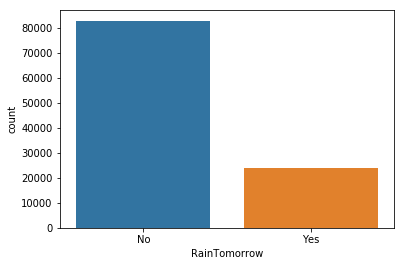

In [83]:
sns.countplot(y_train);

Заменим все пропуски в численных данных средним значением, а все пропуски значением nogGiven

In [84]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

In [85]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

Добавим несколько новых признаков,это будут день недели в году и месяц

In [86]:
def gen_feat(data):
    data['Date']=pd.to_datetime(data.Date)
    data['week']=data['Date'].dt.isocalendar().week
    data['month']=data['Date'].dt.month
gen_feat(X_train)
gen_feat(X_test)

Теперь закодируем категориальные признаки и стандартизируем численные

In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
X_train_tr = column_transformer.fit_transform(X_train)
X_test_tr = column_transformer.transform(X_test)


Будем считать для всех моделей 4 метрики

In [143]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [142]:
%%time
from sklearn.neighbors import KNeighborsClassifier

n_nb = range(1, 9)
nb_acc = []
nb_pr = []
nb_rec = []
nb_f1 = []

for i in n_nb: 
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=4)
    neigh.fit(X_train_tr, y_train)

    prediction = neigh.predict(X_test_tr)

    nb_acc.append(accuracy_score(y_test, regr_prediction))
    nb_pr.append(precision_score(y_test, prediction, pos_label="Yes"))
    nb_rec.append(recall_score(y_test, prediction, pos_label="Yes"))
    nb_f1.append(f1_score(y_test, prediction, pos_label="Yes"))

Wall time: 30min 14s


In [146]:
print(nb_acc)
print(nb_pr)
print(nb_rec)
print(nb_f1)

[0.8525134321640553, 0.8525134321640553, 0.8525134321640553, 0.8525134321640553, 0.8525134321640553, 0.8525134321640553, 0.8525134321640553, 0.8525134321640553]
[0.5695569962182604, 0.7294213528932355, 0.6634987113402062, 0.7489936064409187, 0.7052356020942409, 0.7585585585585586, 0.7284768211920529, 0.7671899181958877]
[0.5307740717432348, 0.33794839521711767, 0.5184392699811202, 0.39811202013845187, 0.5086217747010698, 0.4239144115796098, 0.4984266834487099, 0.4367526746381372]
[0.5494820509479444, 0.46189575090314805, 0.5820674062036317, 0.5198882314266929, 0.5910054844606947, 0.5438837303189342, 0.5918840146476346, 0.5566249598973373]


Выберем лучшие гиперпараметры в зависимости от метрики,которую хотим оптимизировать.
Допустим это F-мера.Тогда наилучшим параметром числа соседей будет 7.


In [147]:
%%time
neigh = KNeighborsClassifier(n_neighbors=7, n_jobs=4)
neigh.fit(X_train_tr, y_train)
prediction = neigh.predict(X_test_tr)

Wall time: 3min 57s


In [148]:
%%time
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty =  'l2', max_iter = 5000, n_jobs=4)
classifier.fit(X_train_tr, y_train)
regr_prediction = classifier.predict(X_test_tr)

Wall time: 10.6 s


In [150]:
%%time
from sklearn.naive_bayes import  GaussianNB

classifier = GaussianNB()
classifier.fit(X_train_tr.toarray(), y_train)
nb_prediction = classifier.predict(X_test_tr.toarray())

Wall time: 19.2 s


In [151]:
print("logistic_regression_accuracy", accuracy_score(y_test, regr_prediction))
print("logistic_regression_precision", precision_score(y_test,regr_prediction, pos_label="Yes"))
print("logistic_regression_recall", recall_score(y_test, regr_prediction, pos_label="Yes"))
print("logistic_regression_f1", f1_score(y_test, regr_prediction, pos_label="Yes"))

logistic_regression_accuracy 0.8525134321640553
logistic_regression_precision 0.7247172322022621
logistic_regression_recall 0.5483952171176841
logistic_regression_f1 0.6243462062047718


In [152]:
print("naive_bayes_accuracy", accuracy_score(y_test, nb_prediction))
print("naive_bayes_precision", precision_score(y_test, nb_prediction, pos_label="Yes"))
print("naive_bayes_recall", recall_score(y_test, nb_prediction, pos_label="Yes"))
print("naive_bayes_f1", f1_score(y_test, nb_prediction, pos_label="Yes"))

naive_bayes_accuracy 0.4611381473459169
naive_bayes_precision 0.2716049382716049
naive_bayes_recall 0.839018250471995
naive_bayes_f1 0.4103669047032751


# Вывод
Были обучены 3 модели :                                         
1.С помощью Байесовских классификаторов                                    
2.С помощью логистической регрессии                                                      
3.С помощью метода ближайших соседей                                                          
Время обучения первой модели: 4 min                                          
Время обучения первой модели: 11s                                                      
Время обучения первой модели: 19s                                                     
Лучшее значение метрики F-measure показала логистическая регрессия - 0.6243                               
метод ближайших соседей чуть хуже - 0.5918                                                                
и наихудшее значение показал Байесовский классификатор - 0.41                                       
В среднем метод ближайших соседей и логистическая регрессия дают схожие результаты на различных метриках, когда Байесовский классификатор сильно отстает в доле верных ответов и точности,но выигрывает в полноте